# MAPD-B distributed processing exam: Analysis of Covid-19 papers

## Part 2: The worst and best represented countries in the research 

Student: Nguyen Xuan Tung

ID: 2005491

##### Library

In [1]:
#pip install fasttext


from collections import Counter
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask import delayed
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pathlib import Path
from gensim.models import KeyedVectors
from tqdm import tqdm

import matplotlib.pyplot as plt
import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
import bokeh.palettes as palette
import dask
import time
import json
import os
import re
import nltk
import sys
import re
import time
import warnings
import nltk
 
from gensim.models.fasttext import FastText
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


#### Create cluster

Check the client and cores. In this case, we have 2 workers are created, each with 1 core corresponding

In [2]:
client = Client()
client

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45055 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37643 Dashboard: http://127.0.0.1:45055/status,Cluster Workers: 2 Cores: 2 Memory: 5.28 GB


In [3]:
print("Python Version : ", sys.version)
print("Dask Version : ", dask.__version__)

Python Version :  3.6.13 | packaged by conda-forge | (default, Sep 23 2021, 07:56:31) 
[GCC 9.4.0]
Dask Version :  2021.03.0


#### Implement

In this section we convert the documents into a usable DataFrame in order to figure out the countries that are most and less active in the research.

Read paper from JSON file

Since the original folder contain too many files (over 20000 files), we made a new folder contains fewer files (2162 files)

In [4]:
path_to_json = 'Covid19_data/document_parses/preprocessed/'

files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

path_to_one_line_json='Covid19_data/document_parses/preprocessed_1'

for i in range(len(files)):
    f = open(files[i],"r")
    f_one_line = open(path_to_one_line_json+str(i)+".json","w+")
    s = f.read()
    s = s.replace('\t','')
    s = s.replace('\n','')
    s = s.replace(" ","")
    
    f_one_line.write( str( re.split("[\n]", s )[0] ) )


f_one_line.close()
f.close() 

Load the files

We use dask bag to read ad process the json data. since the format of json data does not really enforce strict structure and data types, bag objects can be seen as the pythonic version of PySpark RDDs. They hold the standard functional API like map, filter, groupby, etc..

In [5]:
filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(20) 

In [6]:
type(js)

dask.bag.core.Bag

In order to do this, we look at authors entries in each document. As you can notice below, in the metadata -> authors fields there are many keys that are unnecessary for our purpose that we can drop.

In addition, Dask Dataframes expects data that is organized as flat columns. It does not support nested JSON data very well. For this reason we use Dask Bag to flatten down our nested data structure, map that across our records, and then convert that to a Dask Dataframe.

In [7]:
authors = js.pluck('metadata').pluck('authors')

We notice that inside the "author -> affiliation -> location -> country" values there could be reported more than one country and we want to count all of them. In addition, sometimes the name of the country is repeated or is mispelled. So we create a function to flatten information of authors. 

In [8]:
# Flatten information of the authors
def fun(record):
    uni=loc=lab=''
    if 'institution' in record['affiliation'].keys():
        uni=record['affiliation']['institution']
    else: uni="Unknown"
    
    if 'laboratory' in record['affiliation'].keys():
        lab=record['affiliation']['laboratory']
    else: lab="Unknown"
    
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            loc=record['affiliation']['location']['country']
        else: loc="Unknown"
    else: loc="Unknown"
    
    if uni=='': uni="Unknown"
    if lab=='': lab="Unknown"
    if loc=='': loc="Unknown"
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
    }

auth = authors.flatten().map(fun)

In [9]:
auth.take(1)

({'name': 'Alex',
  'surname': 'Ba',
  'University': 'Uniformed Services University of the Health Sciences',
  'Laboratory': 'Unknown',
  'Country': 'USA'},)

In [10]:
df = auth.to_dataframe()
type(df)

dask.dataframe.core.DataFrame

In [11]:
df.head()

,name,surname,University,Laboratory,Country
0,Alex,Ba,Uniformed Services University of the Health Sc...,Unknown,USA
1,|,Robert,Unknown,Unknown,Unknown
2,J,Lewis,Walter Reed National Military Medical Center,Unknown,USA
3,Nora,Watson,Walter Reed National Military Medical Center,Unknown,USA
4,Charles,Riley,Walter Reed National Military Medical Center,Unknown,USA


We create a csv file which contained the name of all countries in the world. 

In [12]:
c_names = np.loadtxt('Countries.txt', delimiter='\n', dtype=str)

In [13]:
type(c_names)
for i in c_names:
    print(i)

﻿
Afghanistan
Albania
Algeria
Andorra
Angola
Antigua & Deps
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Rep
Chad
Chile
China
Colombia
Comoros
Congo
Congo {Democratic Rep}
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland {Republic}
Israel
Italy
Ivory Coast
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Korea North
Korea South
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
Macedonia
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Marshall Islands


Check the name of the country 

In [14]:
def check_country_name(country):

    if ('America' in country) or ('USA' in country):
        return 'United States'
    elif country == 'ROC':
        return 'Taiwan'
    elif country == 'Deutschland':
        return 'Germany'
    elif (country == 'UK') or (country == 'England') :
        return 'United Kingdom'
    elif country=='Schweden':
        return 'Sweden'
    elif country=='España':
        return 'Spain'
    # Check if it's in the txt file
    # i.e. if it is really is a country (not a region and so on)
    elif country in c_names:
        return country
    else:
        return None



In [15]:
df.Country = df.Country.map(check_country_name)

Now we are ready for counting the country's occurrence: since the database has two columns with names of the nation, we have to merge the two counts.

#### Number of occurrences for each country

In [16]:
occ = df.Country.value_counts()
#occ = occ.compute()
#occ = occ.astype(int)
#occurence = occ.compute().sort_values(ascending=False)
occ

Dask Series Structure:
npartitions=1
    int64
      ...
Name: Country, dtype: int64
Dask Name: value-counts-agg, 4488 tasks

In [17]:
%%time
# Compute everything
occ_freq = occ.compute().sort_values(ascending=False)

CPU times: user 18.3 s, sys: 1.23 s, total: 19.5 s
Wall time: 1min 43s


In [18]:
occ_freq.head()

United States     1234
China              939
Italy              472
United Kingdom     351
Spain              295
Name: Country, dtype: int64

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


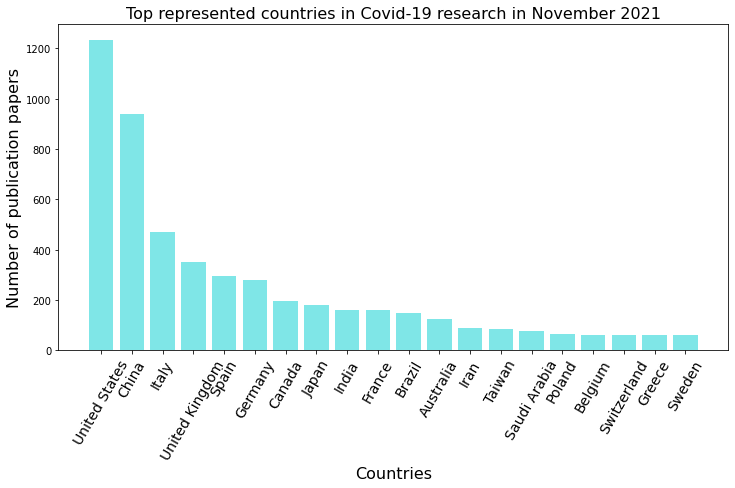

In [19]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occ_freq.index[:20],size=14)

plt.bar(occ_freq.index[:20], occ_freq.values[:20], width, color='darkturquoise',alpha=0.5)
plt.xlabel('Countries', size=16)
plt.ylabel('Number of publication papers', size=16)
plt.xticks(rotation=60)
plt.title('Top represented countries in Covid-19 research in November 2021', size=16)
plt.show()



/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


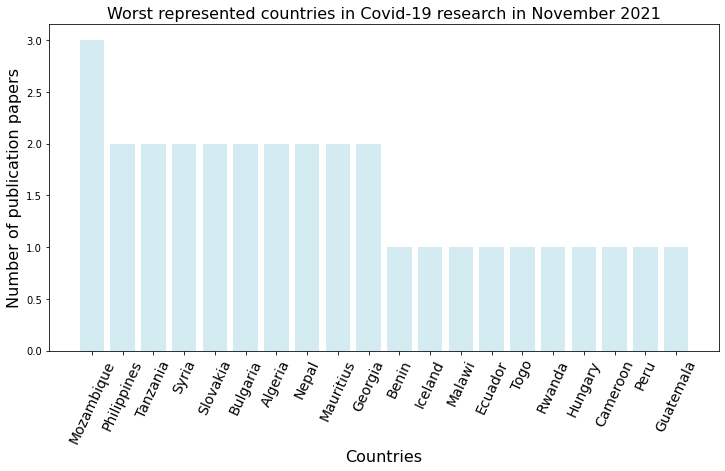

In [20]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8 
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occ_freq.index[-20:],size=14)

plt.bar(occ_freq.index[-20:], occ_freq.values[-20:], width, color='lightblue',alpha=0.5)
plt.xlabel('Countries', size=16)
plt.ylabel('Number of publication papers', size=16)
plt.xticks(rotation=65)
plt.title('Worst represented countries in Covid-19 research in November 2021', size=16)
plt.show()

#### Number of occurrences for each cuniversity

In [21]:
occurrences = df.University.value_counts()

In [22]:
%%time
# Compute everything
occurrences_freq = occurrences.compute().sort_values(ascending=False)

CPU times: user 16.6 s, sys: 1.1 s, total: 17.7 s
Wall time: 1min 38s


In [23]:
occurrences_freq

Unknown                                           7435
University of California                            92
Columbia University                                 89
Chinese Academy of Sciences                         63
Fudan University                                    61
                                                  ... 
Byrd Health Sciences Center                          1
China Academy of Sciences                            1
Children's Hospital of Wisconsin                     1
General Hospital of the Yangtze River Shipping       1
Ospedale Mauriziano Umberto I                        1
Name: University, Length: 2135, dtype: int64

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


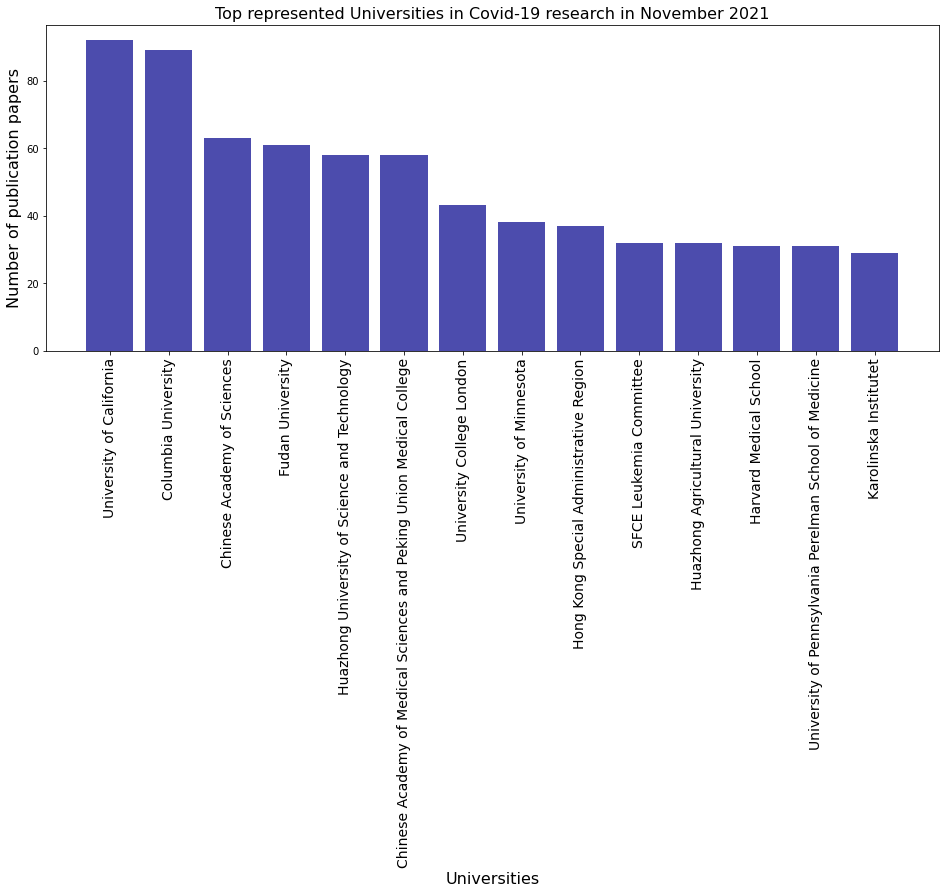

In [24]:
# Plot best represented countries
plt.figure(figsize=(16,6))

width = 0.8
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occurrences_freq.index[1:15],size=14)

plt.bar(occurrences_freq.index[1:15], occurrences_freq.values[1:15], width, color='darkblue',alpha=0.7)
plt.xlabel('Universities', size=16)
plt.ylabel('Number of publication papers', size=16)
plt.xticks(rotation=90)
plt.title('Top represented Universities in Covid-19 research in November 2021', size=16)
plt.show()



/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


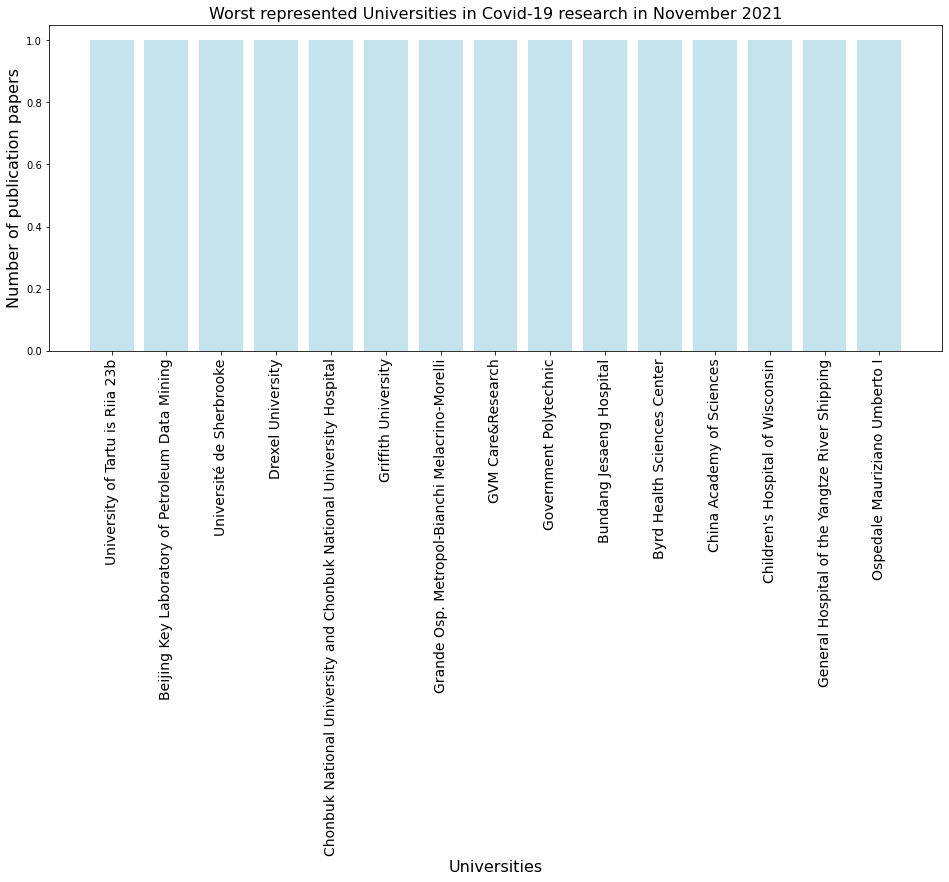

In [25]:
# Plot best represented countries
plt.figure(figsize=(16,6))

width = 0.8
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occurrences_freq.index[-15:],size=14)

plt.bar(occurrences_freq.index[-15:], occurrences_freq.values[-15:], width, color='lightblue',alpha=0.7)
plt.xlabel('Universities', size=16)
plt.ylabel('Number of publication papers', size=16)
plt.xticks(rotation=90)
plt.title('Worst represented Universities in Covid-19 research in November 2021', size=16)
plt.show()



In [26]:
client.close()

#### Effect of number of partitions

In [27]:
partition_time = []
partitions = [1,5,10,20,100]
for n in partitions:
    print('number of partitions:',n)
    
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(n)
    
    # Pluck 'metadata' and then 'authors'
    authors = js.pluck('metadata').pluck('authors')
    auth = authors.flatten().map(fun)
    
    df = auth.to_dataframe()
    
    occurrences = df.University.value_counts()
    
    occurrences_freq = occurrences.compute().sort_values(ascending=False)

    end = time.time()
    
    print('Execution time:',end-start,'\n')
    partition_time.append(end-start)

number of partitions: 1
Execution time: 232.96703362464905 

number of partitions: 5
Execution time: 58.7611870765686 

number of partitions: 10
Execution time: 39.25886154174805 

number of partitions: 20
Execution time: 24.23469114303589 

number of partitions: 100
Execution time: 15.698643684387207 



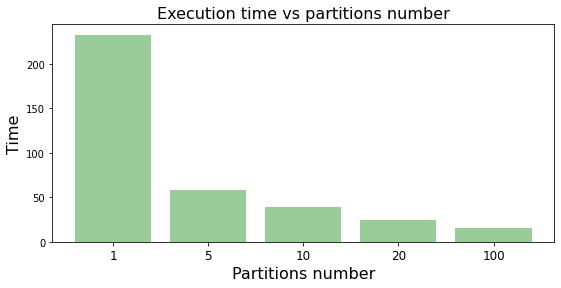

In [28]:
plt.figure(figsize=(9,4))
bar_width = 0.15
plt.bar(range(len(partitions)),partition_time,alpha=0.4,color='g')
plt.xlabel('Partitions number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs partitions number',size=16)
plt.xticks(range(len(partitions)),partitions,size=12)
plt.show() 

We set the partitions to 1, 5, 10, 20, and 100. We can see that the execution time decrease when the number of partition increases. 

In [29]:
client.close()

#### Effect of number of workers

In [30]:
worker_time = []
workers = [1,2,3,4]
for w in workers:
    print('Workers:',w)
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(30)
    
    # Pluck 'metadata' and then 'authors'
    authors = js.pluck('metadata').pluck('authors')
    auth = authors.flatten().map(fun)
    
    df = auth.to_dataframe()
    
    occurrences = df.University.value_counts()
    
    occurrences_freq = occurrences.compute().sort_values(ascending=False)

    end = time.time()
    
    print('Execution time:',end-start,'secs','\n') 
    worker_time.append(end-start) 



Workers: 1


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38739 instead
  http_address["port"], self.http_server.port


Execution time: 83.14410328865051 secs 

Workers: 2


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34349 instead
  http_address["port"], self.http_server.port


Execution time: 117.70135831832886 secs 

Workers: 3


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41591 instead
  http_address["port"], self.http_server.port


Execution time: 136.42966532707214 secs 

Workers: 4


/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33011 instead
  http_address["port"], self.http_server.port


Execution time: 213.39868116378784 secs 



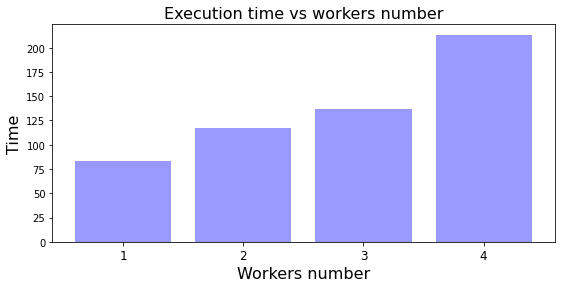

In [31]:
plt.figure(figsize=(9,4))
plt.bar(range(len(workers)),worker_time,alpha=0.4,color='b')
plt.xlabel('Workers number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs workers number',size=16) 
plt.xticks(range(len(workers)),workers,size=12) 
plt.show()

We can see that the second worker took less time to execute than the first one.


In [32]:
client.close()

#### Grid search 

We will now perform an analysis of the effects of the parition and worker by creating a Grid Search.

In [33]:
def comp_time_uni(w,p):
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    start = time.time()
    
    #import the data
    filename = os.path.join('Covid19_data','document_parses', 'preprocessed_1', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(p)
    
    # Pluck 'metadata' and then 'authors'
    authors = js.pluck('metadata').pluck('authors')
    auth = authors.flatten().map(fun)
    
    df = auth.to_dataframe()
    
    occurrences = df.University.value_counts()
    
    occurrences_freq = occurrences.compute().sort_values(ascending=False)
    
    end = time.time()
    client.close()
    return end-start

In [34]:
workers = [1,2,3,4]
partitions = [1,5,20,50,100] # with the same partitions as before
                                     #the kernel stop working
t = np.zeros((len(workers),len(partitions)))
for w in range(len(workers)):
    for p in range(len(partitions)):
        t[w][p] = comp_time_uni(workers[w],partitions[p])

/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36045 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34843 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43063 instead
  http_address["port"], self.http_server.port
/home/locp/anaconda3/envs/myenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38493 in

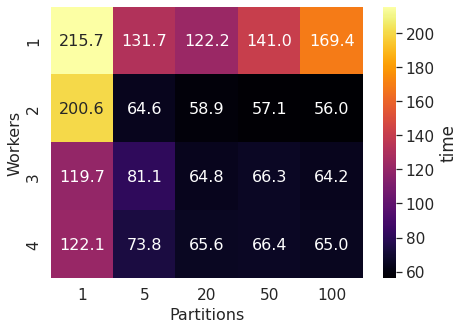

In [35]:
df_grid = pd.DataFrame(t,workers,partitions)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_grid,annot=True, annot_kws={"size": 16},fmt=".1f",
           cbar_kws={'label':'time'},cmap="inferno")
plt.ylabel('Workers',size=16) 
plt.xlabel('Partitions',size=16)   
plt.show()

